# Capstone in Mathematics Final Project
## Linear Regression -- Patrick Thornton
### Package imports

In [41]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sn
import math
import time

### Open and read from data file

In [42]:
def read_data(feature):
    x_data = pd.read_csv(feature)
    x = x_data.values
    return x

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')


### Data Manipulation

In [43]:
# Rename catagory "weathersit" to be more intuitive
train.rename(columns={'weathersit':'weather'},inplace=True)
test.rename(columns={'weathersit':'weather'},inplace=True)

# Drop date column given its integer representation is noise for this model
train = train.drop(['dteday'], axis=1)
test = test.drop(['dteday'], axis=1)

# Change string type columns to catagory typed columns
train['season'] = train.season.astype('category')
train['holiday'] = train.holiday.astype('category')
train['weather'] = train.weather.astype('category')
test['season'] = test.season.astype('category')
test['holiday'] = test.holiday.astype('category')
test['weather'] = test.weather.astype('category')

# Removing weekday improves RMSE by 0.01 for log normal data
# or makes estimate approximatly 1 value closer to true value
train = train.drop(['weekday'],axis=1)
test = test.drop(['weekday'],axis=1)

# Using log to make labels more normally distributed
train['cnt'] = train['cnt'].transform(lambda x: math.log(x))
test['cnt'] = test['cnt'].transform(lambda x: math.log(x))

### Encode features

In [44]:
def one_hot_encoder(df, column):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Source: Predicting bike sharing trends with Python. (2018). 
    # Medium. Retrieved 29 April 2019, from 
    # https://medium.com/@wilamelima/analysing-bike-sharing-trends-with-python-a9f574c596b9
    # 
    # Encode catagorical data to be in seperate columns
    # This avoids the algorithm treating different values with different importance
    # label is 0 -> [1 0 0 0 0 0 0 0 0]
    # label is 3 -> [0 0 0 1 0 0 0 0 0]
    #
    # Parameters:
    # df - dataframe containing data
    # column - column name to be encoded
    # 
    # Results:
    # df - updated dataframe
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=True)],axis=1)
    df = df.drop([column], axis=1)
    return df

# Copy of data to be encoded
train_ohe = train
test_ohe = test

# Columns to be encoded
cats = ['season','holiday','weather']

# Encoding columns one by one in train and test
for cat in cats:
    train_ohe = one_hot_encoder(train_ohe, cat)
    test_ohe = one_hot_encoder(test_ohe, cat)

### Split features and labels

In [45]:
y_train =  train_ohe['cnt']
X_train = train_ohe.drop(['cnt'], axis=1)
y_test =  test_ohe['cnt']
X_test = test_ohe.drop(['cnt'], axis=1)

### Define functions to normalize features

In [46]:
def get_mean_variance(X):
    mean = np.mean(X, axis=0) # axis=0: taking means along the
    # vertical line (column)
    # (sum(x_i-\mu)^2)/N
    X_temp = X - mean #
    X_temp_entrypointwise = X_temp*X_temp
    variance = np.mean(X_temp_entrypointwise, axis=0) #axis=0: 
    # taking means along the vertical line (column)
    return mean, variance
    
def normalize_features(X_train, X_test):
    mean, variance = get_mean_variance(X_train)
    variance += 1e-15
    ''' transform the feature '''
    X_train_norm = (X_train - mean)/np.sqrt(variance)
    X_test_norm = (X_test - mean)/np.sqrt(variance)
    return X_train_norm, X_test_norm

### Execute model

In [47]:
# Start function timer
start = time.time()

def get_optimal_coeffs(x,y):
    xt = x.T
    xtx= xt.dot(x)
    xtx_inv = np.linalg.inv(xtx) # (x^t*x)^(-1)
    optimal_coeffs = (xtx_inv.dot(xt)).dot(y) 
    return optimal_coeffs

def predictor(x, opt_c):
    '''
    x =[x_0, x_1, x_2, ..., x_n]
    c =[c_0, c_1, c_2, ..., c_n]
    x_0 = 1
    c_0: bias
    n=12
    P(x) = <x,c> c_0*1 + c_1*x_crim + c_2*x_zn + c_3*x_indus + c_4*x_chas + c_5*x_nox + c_6*x_rm + c_7*x_age + c_8*x_dis + c_9*x_rad 
    + c_10*x_tax + c_11*x_ptratio + c_12*x_lstat
    '''
    return x.dot(opt_c)


def add_vector_one(x):
    ones = np.ones(x.shape[0])
    ones = ones.reshape(-1,1)
    x_new = np.append(ones, x, axis = 1)
    
    return x_new

x_train_new = add_vector_one(X_train)
x_test_new = add_vector_one(X_test)

opt_coeffs = get_optimal_coeffs(x_train_new, y_train)


print("The predictor is:")
i = 0
for coeff in opt_coeffs:
    if i<1:
        print('p(x) = %.2f' %float(coeff), end = ' ')

    else:
        print('+ %.2f' %float(coeff) + '*x_' + str(i), end = ' ')
    i = i + 1

# List of predicted values using optimal coefficients
y_pred = predictor(x_test_new, opt_coeffs)

# End Function timer
end = time.time()
print("Runtime of linear regression train and predict: ", end-start)
# Used to return labels to real number
# Removes normalizaion, not recommended for anything other than RMSE
y_num = np.asarray([int(math.exp(x)) for x in y_pred])
y_test_num = np.asarray([int(math.exp(x)) for x in y_test])

The predictor is:
p(x) = 2.76 + 0.10*x_1 + 1.77*x_2 + 1.07*x_3 + -1.54*x_4 + 0.17*x_5 + 0.01*x_6 + 0.19*x_7 + 0.52*x_8 + -0.21*x_9 + -0.39*x_10 + 0.29*x_11 Runtime of linear regression train and predict:  0.003003835678100586


# Accuracy

In [48]:
def RMSE(y_pred, y_test):   
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Compare the difference between predicted and real values
    # using root mean square error.
    #
    # Parameters:
    # y_pred - predicted labels using p(x) (vector/list)
    # y_test - actual labels from data (vector/list)
    #
    # Return:
    # rmse - Singular value determined using root mean square error method
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    x = float(len(y_test)) # len () gives an integer value   
    rmse = np.sqrt(sum((y_test-y_pred)**2)/x)
    return rmse

In [49]:
def Pearson(y_pred, y_test):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Partial Source: Python, C., Dali, S., Hammerbacher, J., & Thoma, 
    # M. (2010). Calculating Pearson correlation and significance 
    # in Python. Stack Overflow. Retrieved 29 April 2019, from 
    # https://stackoverflow.com/questions/3949226/calculating-pearson-correlation-and-significance-in-python
    #
    # Compare the difference between predicted and real values
    # using pearson method.
    #
    # Parameters:
    # y_pred - predicted labels using p(x) (vector/list)
    # y_test - actual labels from data (vector/list)
    #
    # Return:
    # Pearson coefficient
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    # Proper variable structure tests
    assert len(y_pred) == len(y_test)
    n = len(y_pred)
    assert n > 0
    
    # Finding averages of vectors using numpy.average()
    avg_pred = np.average(y_pred)
    avg_test = np.average(y_test)
    
    # Variable initialization
    diffprod = 0
    xdiff2 = 0
    ydiff2 = 0
    
    # Determining correlation between each point
    for idx in range(n):
        xdiff = y_pred[idx] - avg_pred
        ydiff = y_test[idx] - avg_test
        diffprod += xdiff * ydiff
        xdiff2 += xdiff * xdiff
        ydiff2 += ydiff * ydiff

    return diffprod / math.sqrt(xdiff2 * ydiff2)

In [50]:
def Spearman(y_pred,y_test):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Compare the difference between predicted and real values
    # using spearman correlation.
    #
    # Parameters:
    # y_pred - predicted labels using p(x) (vector/list)
    # y_test - actual labels from data (vector/list)
    #
    # Return:
    # corr - spearman correlation
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    # Proper variable structure tests
    assert len(y_pred) == len(y_test)
    n = len(y_pred)
    assert n > 0
    
    # Get ranks of labels
    order_pred = y_pred.argsort()
    ranks_pred = order_pred.argsort()
    order_test = y_test.argsort()
    ranks_test = order_test.argsort()
    
    # Finding averages of vectors using numpy.average()
    avg_pred = np.average(ranks_pred)
    avg_test = np.average(ranks_test)
    
    # Variable initialization
    nom = 0 # Nominator of spearman formulation
    left_sum = 0 # Sum of rank of predicted ranks, minus mean rank
    right_sum = 0 # Sum of rank of actual ranks, minus mean rank
    
    for i in range(n):
        left = ranks_pred[i] - avg_pred
        right =  ranks_test[i] - avg_test
        nom += left*right
        left_sum += left*left
        right_sum += right*right
    
    # Final calculation for R_s spearman value
    corr = nom/(math.sqrt(left_sum)*math.sqrt(right_sum))
    
    return corr

In [51]:
def KendallTau(x,y):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Compare the difference between predicted and real values
    # using spearman correlation.
    #
    # Parameters:
    # x - predicted labels using p(x) (vector/list)
    # y - actual labels from data (vector/list)
    #
    # Return:
    # t - Kendall Tau statistic
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    # Proper parameter structure tests
    assert len(x) == len(y)
    n = len(x)
    assert n > 0
    
    # Variable initialization
    p = 0 # Count of concordant values
    q = 0 # Count of discordant values
    x_ties = 0 # Count of ties in predicted values
    y_ties = 0 # Count of ties in actuaL values
    
    # Determining number of concordant, discordant, or tied values
    for i in range(n-1):
        
        # Concordant values
        if x[i] > x[i+1] and y[i] > y[i+1]:
            p += 1
        elif x[i] < x[i+1] and y[i] < y[i+1]:
            p += 1
        
        # Discordant values
        elif x[i] > x[i+1] and y[i] < y[i+1]:
            q+=1
        elif x[i] < x[i+1] and y[i] > y[i+1]:
            q+=1
            
        # Ties
        elif x[i] == x[i+1]:
            x_ties +=1
        elif y[i] == y[i+1]:
            y_ties += 1
        
        # Safty pass
        else:
            pass
    
    # Calculation of Kendall Tau statistic
    t = (p-q)/(math.sqrt(p+q+x_ties)*math.sqrt(p+q+y_ties))
    return t

### Formatting and displaying different correlation values

In [54]:
rmse = RMSE(y_num, y_test_num)
spearman_corr = Spearman(y_pred, y_test)
ken = KendallTau(y_pred, y_test)
pearson_corr = Pearson(y_pred, y_test)

print('The Root Mean Square Error of the data is %.4f' % rmse)
print('The Pearson correlation of the data is %.4f' % pearson_corr)
print('The Spearman correlation of the data is %.4f' % spearman_corr)
print('The Kendall Tau statistic of the data is %.4f' % ken)

The Root Mean Square Error of the data is 162.5652
The Pearson correlation of the data is 0.6848
The Spearman correlation of the data is 0.6766
The Kendall Tau statistic of the data is 0.4757


## Model visualization

<function matplotlib.pyplot.show(*args, **kw)>

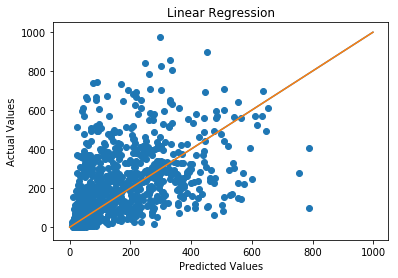

In [53]:
x = np.arange(1000)
y = x
plt.plot(x, y, '-')
plt.scatter(y_num,y_test_num)
plt.plot(x,)
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.title("Linear Regression")
plt.show